# Baseline Model
- We will be using the processed CIFAR-10 dataset to train a baseline CNN model.
- In the baseline model, we will be using the labelled dataset only, and will be testing the model on the test dataset.
- I have also tried a little bit of hyper-parameter tuning in this kernel, regarding the architecture of CNN model, #epochs, etc.
- The hyper-parameter tuning regarding the **#epochs** is fixed and carried out similarly in all the kernels. We have tried **[10, 20, 30, 40, 50]** epochs, and for the final model, selected the setting (#epochs) with the largest test accuracy. 
- There is one slight catch with this kernel. With the GPU, it is not possible to produce 100% reproducible results, even after setting the seeds of all the libraries used. For reference, check this [kernel](https://www.kaggle.com/lbronchal/keras-gpu-cpu-reproducibility-test) out.

# 1. Importing the Packages & Boilerplate Code

In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from tabulate import tabulate
from sklearn.metrics import accuracy_score, log_loss, f1_score

# https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/274717
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
import tensorflow.keras.layers as tfl

In [2]:
# Setting the seeds
SEED = 0
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# Making sure that Tensorflow is able to detect the GPU
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
# These are the usual ipython objects
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Defining a function to list the memory consumed
# Only outputs variables taking at least 1MB space
def list_storage(inp_dir):
    # Get a sorted list of the objects and their sizes
    vars_defined = [x for x in inp_dir if not x.startswith('_') and x not in sys.modules and x not in ipython_vars]
    sto = sorted([(x, sys.getsizeof(globals().get(x))) for x in vars_defined], key=lambda x: x[1], reverse=True)
    sto = [(x[0], str(round((x[1] / 2**20), 2)) + ' MB') for x in sto if x[1] >= 2**20]
    print(tabulate(sto, headers = ['Variable', 'Storage (in MB)']))

# In order to use this function, use the below line of code
# list_storage(dir())

# 2. Data Exploration

(40006, 3072) (40006, 1)
(40006, 3, 32, 32)
[0]


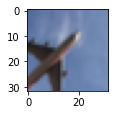

In [5]:
# Importing the Labelled Dataset
df_train = pd.read_csv("../input/cifar10/train_lab_x.csv")
y_train = pd.read_csv("../input/cifar10/train_lab_y.csv")
df_train = np.array(df_train)
y_train = np.array(y_train)
print(df_train.shape, y_train.shape)

# Reshaping the dataset
df_train = np.reshape(df_train, (-1, 3, 32, 32))
print(df_train.shape)

# Visualizing a single image
ind = 11
example = df_train[ind, : , : , : ]
example = example.transpose((1, 2, 0))
plt.figure(figsize=(1.5, 1.5))
plt.imshow(example)
print(y_train[ind])

# 3. Basic Pre-processing

In [6]:
# Creating a random permutation
perm = np.random.permutation(df_train.shape[0])

# Shuffling the training dataset
df_train = df_train[perm, : , : , : ]
y_train = y_train[perm]

# Reshaping, rescaling and one-hot encoding
df_train = np.transpose(np.array(df_train), (0, 2, 3, 1))
df_train = df_train / 255
y_train_oh = tf.one_hot(np.ravel(y_train), depth = 10)

print(df_train.shape, y_train_oh.shape)

(40006, 32, 32, 3) (40006, 10)


# 4. Creating the Model

In [7]:
def cnn_model(input_shape):
    input_img = tf.keras.Input(shape = input_shape)
    
    Z1 = tfl.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu')(input_img)
    B1 = tfl.BatchNormalization(axis=-1)(Z1)
    Z2 = tfl.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu')(B1)
    B2 = tfl.BatchNormalization(axis=-1)(Z2)
    P1 = tfl.MaxPool2D(pool_size=2, strides=2, padding='valid')(B2)
    D1 = tfl.Dropout(0.25)(P1)
    # (16, 16, 16)
    
    Z3 = tfl.Conv2D(32, kernel_size=2, strides=1, padding='valid', activation='relu')(D1)
    B3 = tfl.BatchNormalization(axis=-1)(Z3)
    Z4 = tfl.Conv2D(32, kernel_size=2, strides=1, padding='valid', activation='relu')(B3)
    B4 = tfl.BatchNormalization(axis=-1)(Z4)
    P2 = tfl.MaxPool2D(pool_size=2, strides=2, padding='valid')(B4)
    D2 = tfl.Dropout(0.25)(P2)
    # (7, 7, 32)
    
    F1 = tfl.Flatten()(D2)
    Den1 = tfl.Dense(256, activation='relu')(F1)
    Drop1 = tfl.Dropout(0.25)(Den1)
    Den2 = tfl.Dense(64, activation='relu')(Drop1)
    Drop2 = tfl.Dropout(0.25)(Den2)
    outputs = tfl.Dense(10, activation='softmax')(Drop2)
    
    model = tf.keras.Model(inputs = input_img, outputs = outputs)
    return model

# 5. Compiling, Training, Hyperparameter-Tuning and Evaluating the Model
## 5.1. Compiling the Model & Datasets

In [8]:
conv_model = cnn_model((32, 32, 3))
conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
conv_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 16)        0     

In [9]:
# Composing the Train Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((df_train, y_train_oh)).batch(32)

# Importing the Test Dataset
df_test = pd.read_csv("../input/cifar10/test_x.csv")
y_test = pd.read_csv("../input/cifar10/test_y.csv")
df_test = np.array(df_test)
y_test = np.array(y_test)
print(df_test.shape, y_test.shape)

# Reshaping the dataset
df_test = np.reshape(df_test, (-1, 3, 32, 32))
print(df_test.shape)

# Reshaping, rescaling and one-hot encoding
df_test = np.transpose(np.array(df_test), (0, 2, 3, 1))
df_test = df_test / 255
y_test_oh = tf.one_hot(np.ravel(y_test), depth = 10)
print(df_test.shape, y_test_oh.shape)

(10000, 3072) (10000, 1)
(10000, 3, 32, 32)
(10000, 32, 32, 3) (10000, 10)


## 5.2. Training & Hyperparameter-Tuning for the Model

In [10]:
# If the model has been pre-trained
try:
    conv_model = cnn_model((32, 32, 3))
    conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
    conv_model.load_weights("../input/dcai-rw/baseline_model.h5")

# If the model hasn't been pre-trained
except:
    num_epochs = [10, 20, 30, 40, 50]
    train_loss, test_loss, train_acc, test_acc = [], [], [], []

    for epochs in num_epochs:
        # Training the Model
        conv_model = cnn_model((32, 32, 3))
        conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
        conv_model.fit(train_dataset, epochs = epochs)

        # Predicting on the Train/Test Datasets
        preds_train = conv_model.predict(df_train)
        preds_test = conv_model.predict(df_test)

        # Finding the Predicted Classes
        cls_train = np.argmax(preds_train, axis = 1)
        cls_test = np.argmax(preds_test, axis = 1)

        # Finding the Train/Test set Loss
        train_loss.append(log_loss(y_train_oh, preds_train))
        test_loss.append(log_loss(y_test_oh, preds_test))
        train_acc.append(accuracy_score(y_train, cls_train))
        test_acc.append(accuracy_score(y_test, cls_test))

        print("For ", epochs, " Epochs:")
        print("Log-loss for Train Dataset = ", train_loss[-1])
        print("Log-loss for Test Dataset = ", test_loss[-1])
        print("Accuracy for Train Dataset = ", train_acc[-1])
        print("Accuracy for Test Dataset = ", test_acc[-1])
        print()
    
    # Training the Model with the best hyper-parameter settings
    ind = np.argmax(test_acc)
    best_num_epochs = num_epochs[ind]
    conv_model = cnn_model((32, 32, 3))
    conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
    conv_model.fit(train_dataset, epochs = best_num_epochs)

    # Saving the model along with it's weights
    conv_model.save('baseline_model.h5')

## 5.3. Evaluating/Inferencing on the Train/Test Sets

In [11]:
# Predicting on the Train/Test Datasets
preds_train = conv_model.predict(df_train)
preds_test = conv_model.predict(df_test)

# Finding the Predicted Classes
cls_train = np.argmax(preds_train, axis = 1)
cls_test = np.argmax(preds_test, axis = 1)

In [12]:
# Finding the Train/Test set Loss
print("Log-loss for Train Dataset = ", log_loss(y_train_oh, preds_train))
print("Log-loss for Test Dataset = ", log_loss(y_test_oh, preds_test))
print("Weighted F1 Score for Train Dataset = ", f1_score(y_train, cls_train, average = 'weighted'))
print("Weighted F1 Score for Test Dataset = ", f1_score(y_test, cls_test, average = 'weighted'))
print("Accuracy for Train Dataset = ", accuracy_score(y_train, cls_train))
print("Accuracy for Test Dataset = ", accuracy_score(y_test, cls_test))

Log-loss for Train Dataset =  0.07668840324139689
Log-loss for Test Dataset =  0.780156585093371
Weighted F1 Score for Train Dataset =  0.9808037008857216
Weighted F1 Score for Test Dataset =  0.7805332999350915
Accuracy for Train Dataset =  0.9808528720691896
Accuracy for Test Dataset =  0.7822
